In [55]:
from __future__ import division
%matplotlib inline
import CameraNetwork.sunphotometer as spm
import cPickle
import datetime
from dateutil import parser
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 16.0)
import numpy as np
import os
import pandas as pd
idx = pd.IndexSlice
from pyspectral.solar import (SolarIrradianceSpectrum,
                              TOTAL_IRRADIANCE_SPECTRUM_2000ASTM)
from scipy.optimize import curve_fit

## Load the Camera Quantum Efficiency Curves

In [83]:
base_path = r"..\..\data\camera_QE"
blue_df = pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-blue auto.csv"), names=["wavelength", "QE"])
green_df = pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-green auto.csv"), names=["wavelength", "QE"])
red_df = pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-red auto.csv"), names=["wavelength", "QE"])

max_wavelength = 700

blue_df = blue_df[blue_df["wavelength"] < max_wavelength]
green_df = green_df[green_df["wavelength"] < max_wavelength]
red_df = red_df[red_df["wavelength"] < max_wavelength]

### Fit Gaussians to the QEs

Fitted mean =  456.557197763
Fitted standard deviation =  48.6590870568
Fitted mean =  539.38046592
Fitted standard deviation =  43.6141500527
Fitted mean =  634.305023316
Fitted standard deviation =  51.7921941198


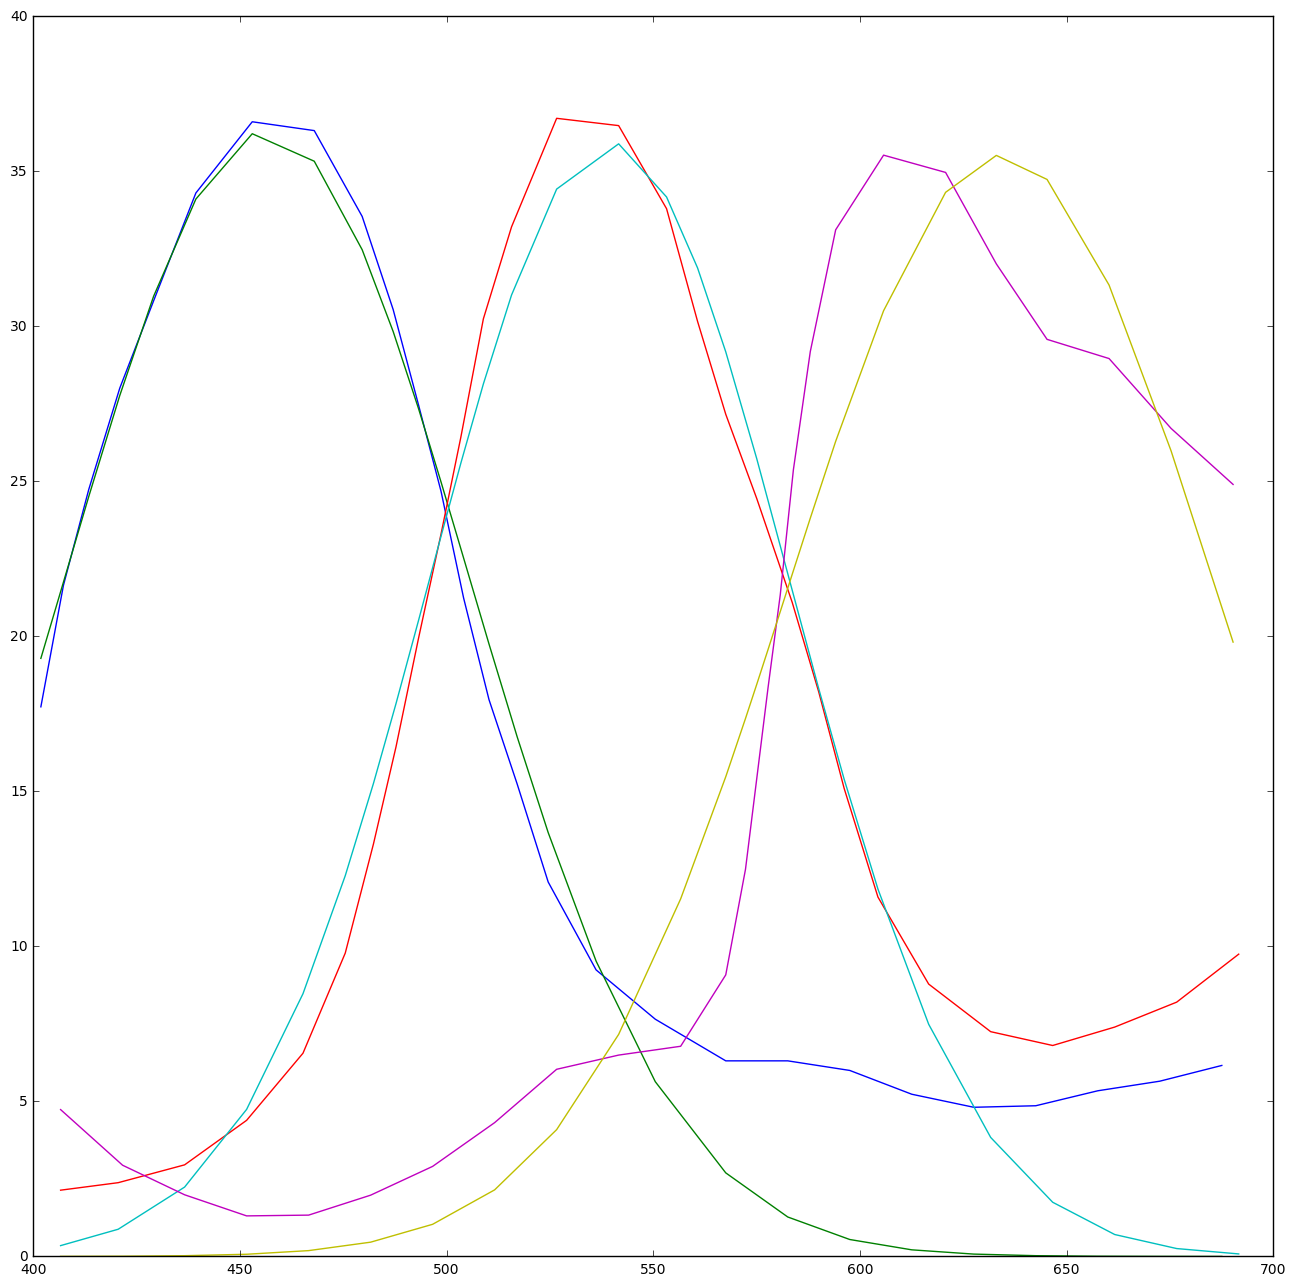

In [66]:
#
# Define model function to be used to fit to the data above:
#
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

gaussian_params = []
for df in (blue_df, green_df, red_df):
    #
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    #
    p0 = [np.max(df["QE"]), 550., 50.]

    coeff, var_matrix = curve_fit(gauss, df["wavelength"], df["QE"], p0=p0)

    #
    # Get the fitted curve
    #
    hist_fit = gauss(df["wavelength"], *coeff)

    plt.plot(df["wavelength"], df["QE"], label='Test data')
    plt.plot(df["wavelength"], hist_fit, label='Fitted data')

    # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
    print 'Fitted mean = ', coeff[1]
    print 'Fitted standard deviation = ', coeff[2]
    
    gaussian_params.append((1, coeff[1]/1000, coeff[2]/1000))

## Sepctral Data

Total Top of Atmosphere (TOA) Solar Irradiance Spectrum Wavelength is in units of microns (10^-6 m). The spectral Irradiance in the file TOTAL_IRRADIANCE_SPECTRUM_2000ASTM is in units of W/m^2/micron

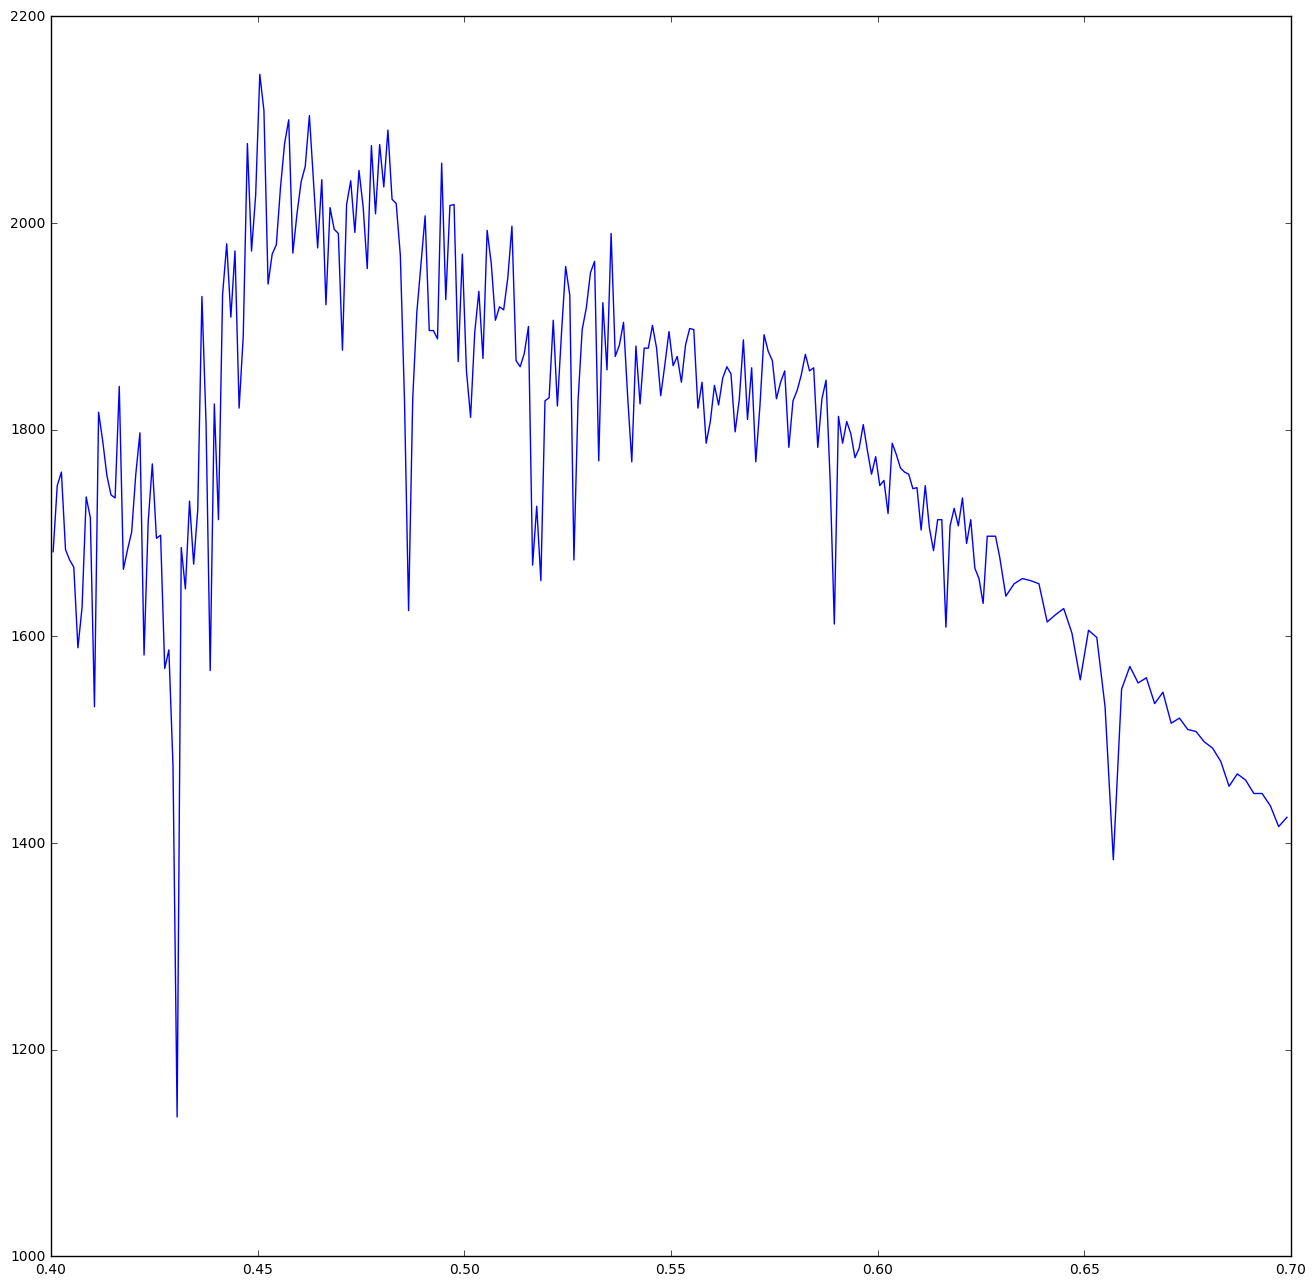

In [52]:
solar_irr = \
    SolarIrradianceSpectrum(TOTAL_IRRADIANCE_SPECTRUM_2000ASTM, dlambda=0.005)
solar_df = pd.DataFrame(dict(wavelength=solar_irr.wavelength, irradiance=solar_irr.irradiance))
solar_df = solar_df[(solar_df["wavelength"]>0.400)&(solar_df["wavelength"]<0.700)]
plt.plot(solar_df["wavelength"], solar_df["irradiance"])

### Calculate the Flux

Aviad uses the red channel in the pyshdom.

In [93]:
TEST_RSR = {}
TEST_RSR['det-1'] = dict(
    wavelength=solar_df["wavelength"].values,
    response=gauss(solar_df["wavelength"], *gaussian_params[2])
    )

In [95]:
flux_green = solar_irr.inband_solarflux(TEST_RSR, scale=1.0)
print("Flux in uW/cm^2: {}".format(flux_green*1e6/1e2/1e2))

Flux in uW/cm^2: 19338.1532981


## Load the Sunphotometer Single Scattering Albedo data

In [92]:
df = spm.parseSunPhotoMeter(r'..\..\data\aeronet\2017_04\170422_170422_Technion_Haifa_IL.ssa')
df.head()

,Julian_Day,SSA441-T,SSA674-T,SSA871-T,SSA1020-T,last_processing_date(mm/dd/yyyy),alm_type,solar_zenith_angle_for_1020nm_scan,sky_error,sun_error,...,scat_angle_1020(>=3.2to6),scat_angle_1020(>=6to30),scat_angle_1020(>=30to80),scat_angle_1020(>=80),albedo_440,albedo_675,albedo_870,albedo-1020,average_solar_zenith_angle_for_flux_calculation,DATA_TYPE
Date(dd-mm-yyyy)_Time(hh:mm:ss),,,,,,,,,,,,,,,,,,,,,
2017-04-22 04:19:15,112.180035,0.8797,0.9247,0.9302,0.9372,26/04/2017,0,74.848008,3.874145,0.005485,...,4,10,4,5,0.05228,0.14077,0.33591,0.33844,74.225759,Level_1.5
2017-04-22 04:43:21,112.196771,0.8921,0.9365,0.9427,0.9492,26/04/2017,0,69.803218,4.782619,0.007024,...,4,10,5,5,0.05017,0.13461,0.31785,0.31683,69.078535,Level_1.5
2017-04-22 05:33:17,112.231447,0.9122,0.9488,0.9562,0.9609,26/04/2017,0,59.326484,4.584084,0.011117,...,3,10,6,4,0.04670,0.12384,0.28855,0.28927,58.718886,Level_1.5
2017-04-22 06:40:30,112.278125,0.8948,0.9252,0.9311,0.9375,26/04/2017,0,45.449479,2.974542,0.016758,...,4,10,5,3,0.04430,0.11600,0.26678,0.26684,44.901980,Level_1.5
2017-04-22 12:40:33,112.528160,0.8756,0.9212,0.9334,0.9426,26/04/2017,0,46.263609,4.767822,0.018390,...,2,10,8,3,0.04462,0.11697,0.26901,0.26782,46.847872,Level_1.5
